# The Barabási-Albert model and the Configuration model

## The Barabási-Albert model

We are going to generate B-A random graphs with the help of Networkx, and examine the degree distribution of the obtained networks.

In [1]:
import networkx as nx;
import numpy as np;
import matplotlib.pyplot as plt;

First let's just try out the generator provided by Networkx with a small network:

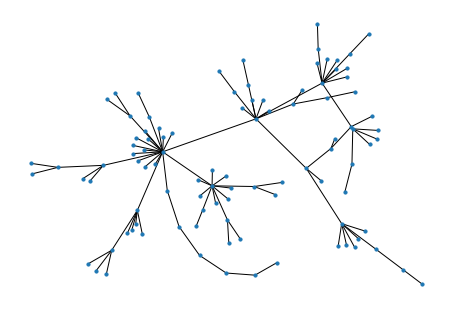

In [2]:
BA_graph = nx.generators.barabasi_albert_graph(100,1); # 1st. param. is N, the 2nd param. is m, the number of links
nx.draw(BA_graph,node_size=10)                         # on the new nodes 

Next, we are going to examine the degree distribution of B-A networks generated with Networkx. The concept is simple: we generate multiple samples with the same $N$ and $m$ parameters, and collect the node degrees from all samples into a single long list. Based on that, we prepare a normalised degree histogram, which is corresponding to the $p(k)$ averaged over all samples.

In [3]:
N,m, num_samples = 100000,1,10;   # the parameters of our analysis

node_degree_collection = [];      # this going to be the list of observed node degrees across all samples    
node_degree_collection.clear();
for i in range(0,num_samples):
    print('B-A net. no. ',i);
    BA_net = nx.generators.barabasi_albert_graph(N,m);
    for node in BA_net.nodes:
        node_degree_collection.append(BA_net.degree(node));

B-A net. no.  0
B-A net. no.  1
B-A net. no.  2
B-A net. no.  3
B-A net. no.  4
B-A net. no.  5
B-A net. no.  6
B-A net. no.  7
B-A net. no.  8
B-A net. no.  9


We can use numpy.histogram to prepare the normalised $p(k)$. 

However, in order to see the difference between just a single sample and averaging over a larger number of samples, we are also going to plot the $p(k)$ for the first network among the samples beside the average $p(k)$ taken over all samples. The node degrees in the first network are easy to get: they correspond to the first $N$ entries in our large 'concataneted' list.

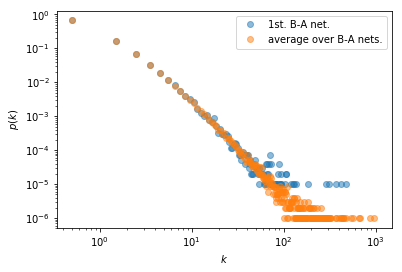

In [4]:
first_net_degs = node_degree_collection[0:N];

max_k = max(node_degree_collection);
degree_bins = np.arange(0.5,max_k+0.5,1.0);

first_pk, first_bins = np.histogram(first_net_degs,degree_bins,density = True);
average_pk, av_bins = np.histogram(node_degree_collection,degree_bins,density=True);

plt.clf();
plt.loglog(first_bins[:-1],first_pk,'o',alpha = 0.5,label = '1st. B-A net.');
plt.loglog(av_bins[:-1],average_pk,'o',alpha = 0.5,label = 'average over B-A nets.');
plt.legend();
plt.xlabel('$k$');
plt.ylabel('$p(k)$');

**Observations:**
- the $p(k)$ looks **scale-free!!**
- when taking more samples, the decay in the data following a straight line on the log-log plot is observable over a larger interval.

## The configuration model

Luckily, Networkx has also a random generator for the configuration model, where the input parameter is corresponding to the list of node degrees we would like to have in the network.

Let's try it out by just copying the degrees from our first small Barabási-Albert network!

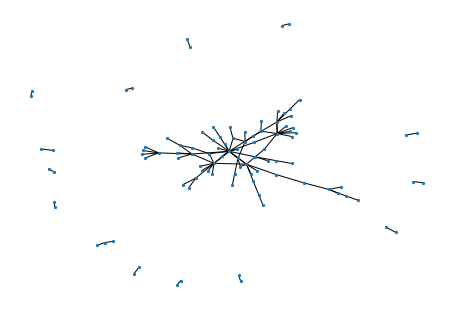

In [5]:
BA_degs = [BA_graph.degree(node) for node in BA_graph.nodes]
config_net = nx.generators.configuration_model(BA_degs);      # the parameter is a list of degrees
nx.draw(config_net,node_size=5)

**WARNING** 

Although the use of this network generator is simple and confortable, however, if you check its documentation, it turns out that the returned object is in fact a **multigraph**. Thus, in the network returned by this function we can have multiple links betwen the same node pair and also self-connections. This is true even when you copy the input degrees from a simple graph.

So what can we do, if we analyse a real network, and would like to compare it to the configuration model, however, we would also like to keep this random base line a simple graph?

The solution is to define a function implementing the link randomisation discussed in the slides. We can define this function in such a way that it is guaranteed that it will not produce multi links and self connections:

In [6]:
def Link_randomise_Graph(orig_net,num_rewirings):   # 2nd argument is the number of rewirings
    _copy_net = orig_net.copy();
    _rews = int(0);
    while _rews < num_rewirings:
        _link_list = list(_copy_net.edges());
        _rand_edge_inds = np.random.randint(0,len(_link_list),2);
        if _rand_edge_inds[0] != _rand_edge_inds[1]:                  
            _s1,_t1 = _link_list[_rand_edge_inds[0]][0],_link_list[_rand_edge_inds[0]][1];
            _s2,_t2 = _link_list[_rand_edge_inds[1]][0],_link_list[_rand_edge_inds[1]][1];
            if len(set([_s1,_t1,_s2,_t2])) == 4:         
                _s1_neighs = _copy_net.neighbors(_s1);
                _s2_neighs = _copy_net.neighbors(_s2);
                if (not _t2 in _s1_neighs) and (not _t1 in _s2_neighs):
                    _copy_net.remove_edge(_s1,_t1);
                    _copy_net.remove_edge(_s2,_t2);
                    _copy_net.add_edge(_s1,_t2);
                    _copy_net.add_edge(_s2,_t1);
                    _rews += 1;  
    return _copy_net;

Let's try this out on a real network we already encountered on a previous lecture. We are going to randomise the network, and keep track of the change in the clustering coefficient as a function of the number of rewired links.

First we read the network from the input file:

In [7]:
protein_net = nx.read_edgelist('protein.edgelist.txt');
print('N = ',protein_net.number_of_nodes(),' L = ',protein_net.number_of_edges());

N =  2018  L =  2930


Since the total number of rewirings needed according to the rule of the thumb given in the slides is of the order of thousands, we are not going to calculate the clustering coefficient after each individual rewiring step, instead only after each say 50 rewirings.

In [8]:
total_num_rew, steps = protein_net.number_of_edges()*2, 50; # total number of rewirings, and after how many steps
                                                            # do we actually calculate the clustering coeff.
prot_copy = protein_net.copy();                          
rand_steps, clust_list = [0],[nx.average_clustering(prot_copy)]; # we collect the results into these lists.
for i in range(1,int(total_num_rew/steps)):
    prot_copy = Link_randomise_Graph(prot_copy,steps);      # here we rewire 50 times in one go.
    rand_steps.append(i*steps);
    clust = nx.average_clustering(prot_copy);               # and then calculate C.
    clust_list.append(clust);
    print(i*steps,' rand. rew., C = ',clust);

50  rand. rew., C =  0.04199314328843542
100  rand. rew., C =  0.03886167740153096
150  rand. rew., C =  0.03768811801950161
200  rand. rew., C =  0.03211103867157773
250  rand. rew., C =  0.030628655846657988
300  rand. rew., C =  0.028983248610190124
350  rand. rew., C =  0.02633119677107639
400  rand. rew., C =  0.02443087461584243
450  rand. rew., C =  0.020814753181949162
500  rand. rew., C =  0.018618781857681923
550  rand. rew., C =  0.017305173496394554
600  rand. rew., C =  0.0156353511253188
650  rand. rew., C =  0.01432816177574265
700  rand. rew., C =  0.014060747702066995
750  rand. rew., C =  0.011276796139630079
800  rand. rew., C =  0.010799345395850039
850  rand. rew., C =  0.012142644528787922
900  rand. rew., C =  0.012118669608523177
950  rand. rew., C =  0.010702263452724717
1000  rand. rew., C =  0.010145602947696591
1050  rand. rew., C =  0.009791938357564228
1100  rand. rew., C =  0.01071226687438162
1150  rand. rew., C =  0.00961357010183559
1200  rand. rew., C

Let's plot the results.

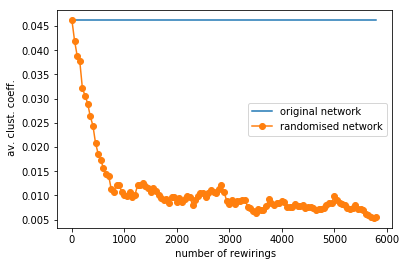

In [9]:
clust_in_original_net = [clust_list[0] for step in rand_steps];

plt.clf();
plt.plot(rand_steps,clust_in_original_net,'-',label = 'original network');
plt.plot(rand_steps,clust_list,'o-',label = 'randomised network');
plt.xlabel(' number of rewirings');
plt.ylabel(' av. clust. coeff.');
plt.legend();
plt.show();

Let's also check that the degree distribution of the randomised network is still the same as the degree distribution of the original network:

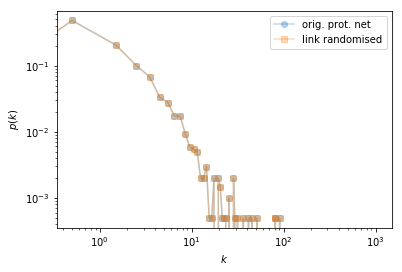

In [10]:
prot_deg_list = [protein_net.degree(node) for node in protein_net.nodes];
copy_deg_list = [prot_copy.degree(node) for node in prot_copy.nodes];

prot_max_k = max(prot_deg_list);
prot_deg_bins = np.arange(-0.5,max_k+0.5,1.0);

prot_pk,p_bins = np.histogram(prot_deg_list,prot_deg_bins,density=True);
copy_pk,c_bins = np.histogram(copy_deg_list,prot_deg_bins,density=True);

plt.clf();
plt.loglog(p_bins[:-1],prot_pk,'o-',label = 'orig. prot. net',alpha = 0.3);
plt.loglog(c_bins[:-1],copy_pk,'s-',label = 'link randomised',alpha = 0.3);
plt.xlabel('$k$');
plt.ylabel('$p(k)$');
plt.legend();
plt.show();